## Libraries 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples,silhouette_score

%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import datetime as dt



## Data Loading
Data is Mall Customers dataset found on kaggle which is pre

In [ ]:
df = pd.read_csv(r'/content/drive/MyDrive/Online Retail.csv')
df.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

    InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/10 8:26       2.55     17850.0  United Kingdom  
1  12/1/10 8:26       3.39     17850.0  United Kingdom  
2  12/1/10 8:26       2.75     17850.0  United Kingdom  
3  12/1/10 8:26       3.39     17850.0  United Kingdom  
4  12/1/10 8:26       3.39     17850.0  United Kingdom

In [ ]:
df.shape

(541909, 8)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [ ]:
# this line converts the object type of Invoice Date Column to datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'],format='%m/%d/%y %H:%M')

## Visuals

<b>Business Case : What is the most Countries where sales were encountered ? </b>

Future Implementation : Can check sales by countries so we get RFM on country based too. Where is the most products sold 

In [ ]:
len(df['Country'].unique())

38

In [ ]:
con_inv = df.groupby('Country')['InvoiceNo'].count()
con_inv = con_inv.reset_index()
con_inv.columns = ['Country', 'Frequency']
con_inv.head()
a=con_inv.sort_values(by='Frequency',ascending=False)

In [ ]:
import plotly.express as px
fig = px.choropleth(con_inv, locations="Country", 
                    locationmode='country names', color="Frequency", 
                    hover_name="Country", range_color=[1,1000], 
                    color_continuous_scale="blues", 
                    title='No of sales by Countries')
fig.update(layout_coloraxis_showscale=True)
fig.show(renderer="colab")


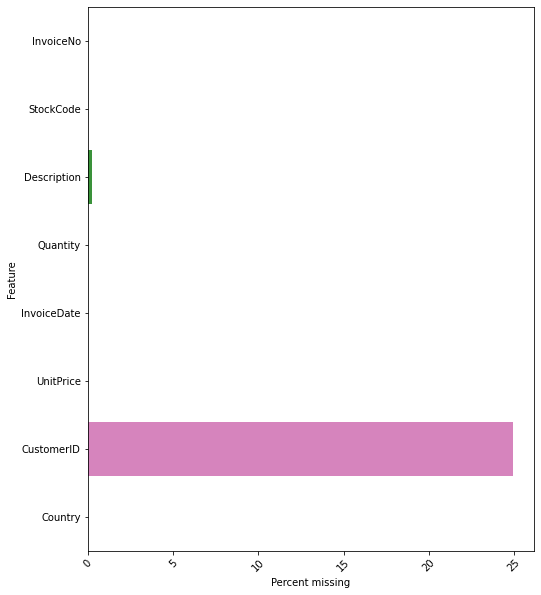

In [ ]:
null_vals = df.isnull().sum()/len(df)*100
null_vals = pd.DataFrame(null_vals)
null_vals.reset_index(inplace = True)
null_vals.columns = ["Feature","Percent missing"]
plt.figure(figsize = (8,10))
plt.xticks(rotation=45)
sns.barplot(x = "Percent missing",y ="Feature",data = null_vals,orient = "h")

## Data Engineering/Manipulation to get accurate results and remove outliers 

Why we are dropping columns?

---
Description is categorical data we cannot use that in K-means and other like stock type cannot be used with K-Means

In [ ]:
df=df[['InvoiceNo','Quantity','InvoiceDate','UnitPrice','CustomerID']]

In [ ]:
# data engineering removing na is very important in k-means if we want accurate data, there is another method which is called imputing : 
# Statistical Imputation
# Horse Colic Dataset
# Statistical Imputation With SimpleImputer but in our case Customer ID and description cannot be imputed since desc is text and Customer ID is linear number there is no measures
df = df.drop_duplicates()


In [ ]:
df = df.dropna(subset = ["CustomerID"])

In [ ]:
# Muliplying Quantity to Per product price so  example customer bought a product of 2 dollars and he took 5 of them so 2X5=10 total price 
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
print(df.shape)
df.head(2)

(255400, 6)


InvoiceNo  Quantity         InvoiceDate  UnitPrice  CustomerID  TotalPrice
0    536365         6 2010-12-01 08:26:00       2.55     17850.0       15.30
1    536365         6 2010-12-01 08:26:00       3.39     17850.0       20.34

In [ ]:
## to find the range of dates : So we get its one year data ~ 365 days 
print('Min:{}; Max:{}'.format(df["InvoiceDate"].min(), df["InvoiceDate"].max()))

Min:2010-12-01 08:26:00; Max:2011-12-09 12:50:00


Why we take correlation of Variables ? <br>


Inorder to get the best variables and their compatibility of the variables 

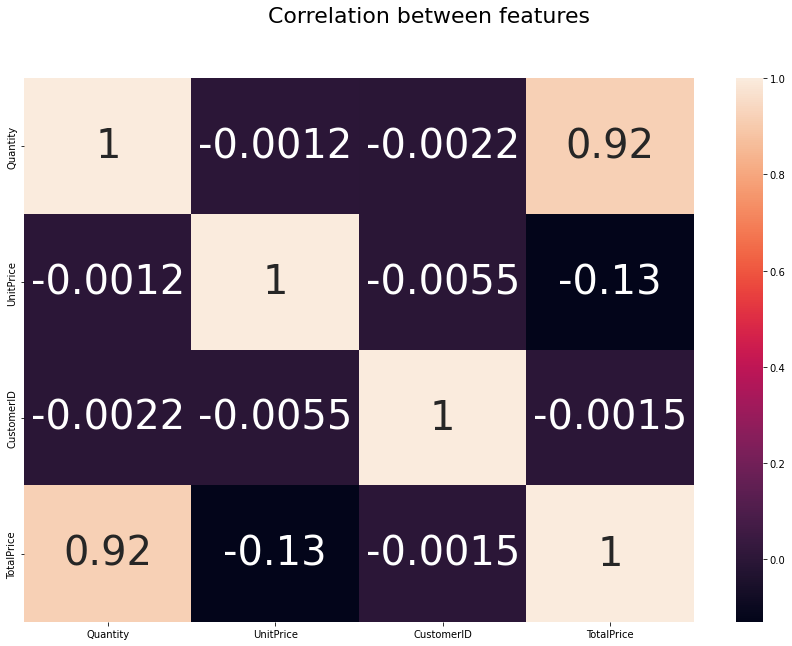

In [ ]:
# Correlation between features 

plt.subplots(figsize=(15,10))
plt.suptitle("Correlation between features", fontsize=22)
sns.heatmap(df.corr(), annot=True, annot_kws={"size": 40})
plt.show(); 

In [ ]:
## Setting current data after the latest invoice so we can get what is the recent transaction made by customer so if recency is 325 the customer must have shopped in Jan 2011
current_date = dt.datetime(2011,12,10)

##Recency Frequency Monteary & Data distribution

In [ ]:
## Implemented RFM as per professor videos but got the concept learned first time but helpful :)

df1 = df.groupby(['CustomerID']).agg({ 'InvoiceDate': lambda x: (current_date - x.max()).days, 'InvoiceNo': 'count','TotalPrice': 'sum'})
df1.rename(columns = {'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency','TotalPrice': 'Monetary'}, inplace=True)
print(df1.shape)
df1.head(3)

(4372, 3)


Recency  Frequency  Monetary
CustomerID                              
12346.0         325          2      0.00
12347.0           2        116   3125.98
12348.0          75         20   1399.80

If we now see the Shape of data is 4372 before dropping 0 values. Dropping them will be helpful because it will lead our model in wrong direction,Monetary can be 0 when transaction made and frequency became as 1 and he returned the product so another transacation recorded so we didn't make any sales from this transaction , to included such data is pointless.

In [ ]:
df1.shape

(4372, 3)

In [ ]:
df5 = df1[(df1 > 0).all(1)]
print(df5.shape)

(4279, 3)


Here means and standard deviations are not equal it has alot of difference

In [ ]:
df5.describe()

Recency    Frequency      Monetary
count  4279.000000  4279.000000  4.279000e+03
mean     90.733583    57.186025  1.323727e+03
std      99.232327   124.064908  5.493201e+03
min       1.000000     1.000000  3.552714e-15
25%      17.000000    12.000000  2.168500e+02
50%      50.000000    28.000000  4.808000e+02
75%     140.000000    64.000000  1.121445e+03
max     373.000000  4384.000000  2.016428e+05

Distplot with KDE's to see the distribution of overall data

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



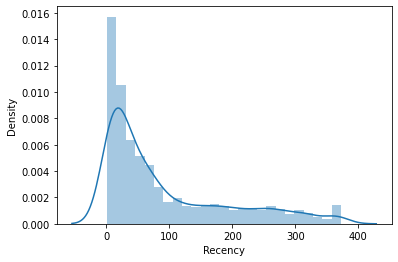

In [ ]:
sns.distplot(df5['Recency'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



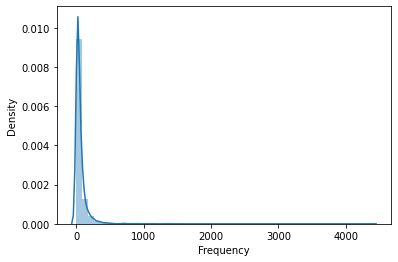

In [ ]:
sns.distplot(df5['Frequency'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



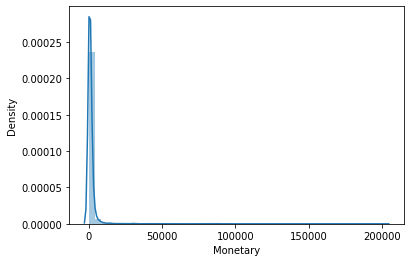

In [ ]:
sns.distplot(df5['Monetary'])

## Removing Statistical Outliers <br>
##Why? <br>
Interquartile range gives another measure of variability. It is a better measure of dispersion than range because it leaves out the extreme values. It equally divides the distribution into four equal parts called quartiles. First 25% is 1st quartile (Q1), last one is 3rd quartile (Q3) and middle one is 2nd quartile (Q2).<br>

2nd quartile (Q2) divides the distribution into two equal parts of 50%. So, basically it is same as Median.<br>

The interquartile range is the distance between the third and the first quartile, or, in other words, IQR equals Q3 minus Q1

IQR = Q3- Q1

How to calculate IQR
Step 1: Order from low to high

Step 2: Find the median or in other words Q2

Step 3: Then find Q1 by looking the median of the left side of Q2

Steps 4: Similarly find Q3 by looking the median of the right of Q2

Steps 5: Now subtract Q1 from Q3 to get IQR.
<br>

<img src="https://makemeanalyst.com/wp-content/uploads/2017/05/IQR-1.png">

In [ ]:
# Removing (statistical) outliers for Recency
q1 = df5.Recency.quantile(0.05)
q3 = df5.Recency.quantile(0.95)
IQR = Q3 - q1
df5 = df5[(df5.Recency >= q1 - 1.5*IQR) & (df5.Recency <= q3 + 1.5*IQR)]
 
# Removing (statistical) outliers for Frequency
q1 = df5.Frequency.quantile(0.05)
q3 = df5.Frequency.quantile(0.95)
IQR = q3 - q1
df5 = df5[(df5.Frequency >= q1 - 1.5*IQR) & (df5.Frequency <= q3 + 1.5*IQR)]

# Removing (statistical) outliers for Monetary
q1 = df5.Monetary.quantile(0.05)
q3 = df5.Monetary.quantile(0.95)
IQR = q3 - q1
df5 = df5[(df5.Monetary >= q1 - 1.5*IQR) & (df5.Monetary <= q3 + 1.5*IQR)]

NameError: ignored

If we compare the mean and std  of above and now we get difference 

In [ ]:
df5.describe()

Recency    Frequency      Monetary
count  4201.000000  4201.000000  4.201000e+03
mean     92.214949    48.770055  8.858064e+02
std      99.477156    59.466105  1.160966e+03
min       1.000000     1.000000  3.552714e-15
25%      17.000000    12.000000  2.127000e+02
50%      51.000000    27.000000  4.659200e+02
75%     143.000000    62.000000  1.054100e+03
max     373.000000   472.000000  8.770140e+03

After performing Standard scaler got mean differene by it has same power and same standard deviation. 

I read article from here to get to know the backend of standard scaler 
https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02#:~:text=StandardScaler%20is%20the%20industry's%20go,of%20scale%20I%20introduced%20earlier.

In [ ]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
df_scaled = pd.DataFrame(ss.fit_transform(df5), columns = df5.columns)
df_scaled.head()

Recency  Frequency  Monetary
0 -0.906999   1.130694  1.929807
1 -0.173075  -0.483864  0.442782
2 -0.746139  -0.063406  0.278839
3  2.189558  -0.668865 -0.613016
4 -0.565171   0.474780  0.335453

In [ ]:
df_scaled.describe()

Recency     Frequency      Monetary
count  4.201000e+03  4.201000e+03  4.201000e+03
mean  -8.456829e-19 -4.312983e-17  8.795102e-17
std    1.000119e+00  1.000119e+00  1.000119e+00
min   -9.170528e-01 -8.034113e-01 -7.630817e-01
25%   -7.561927e-01 -6.184100e-01 -5.798503e-01
50%   -4.143650e-01 -3.661354e-01 -3.617129e-01
75%    5.105805e-01  2.225052e-01  1.449773e-01
max    2.822944e+00  7.118010e+00  6.791993e+00

Added Log to plot graph with properly and not skewed

In [ ]:
df_scaled = (np.log(df_scaled + 1))
print(df_scaled.shape)
df_scaled.head(3)


(4201, 3)


Recency  Frequency  Monetary
0 -2.375146   0.756448  1.074937
1 -0.190041  -0.661384  0.366573
2 -1.370968  -0.065505  0.245952

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



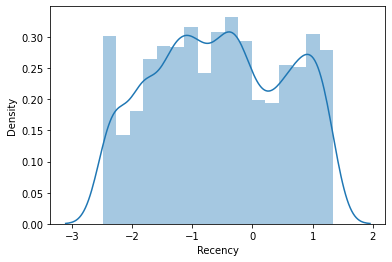

In [ ]:
sns.distplot(df_scaled['Recency'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



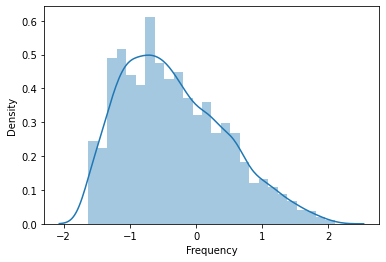

In [ ]:
sns.distplot(df_scaled['Frequency'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



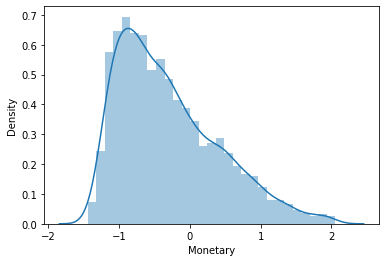

In [ ]:
sns.distplot(df_scaled['Monetary'])

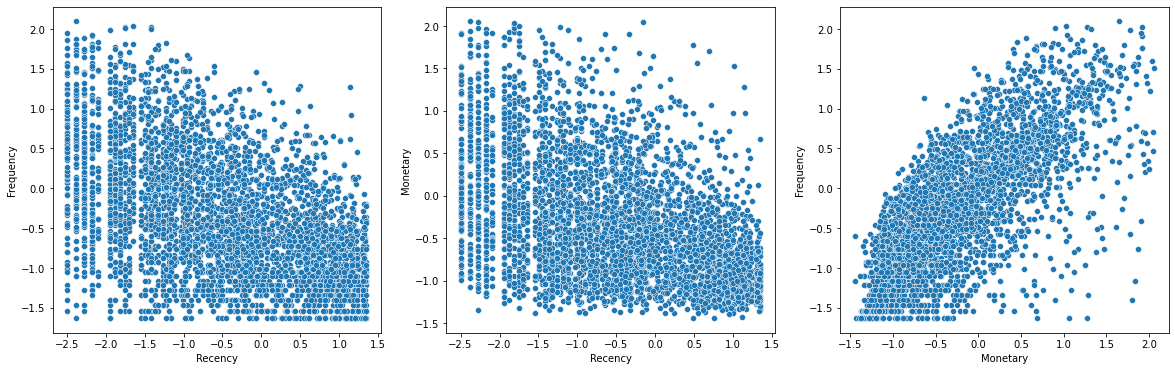

In [ ]:
plt.figure(figsize = (20,6))

plt.subplot(1,3,1)

sns.scatterplot(data = df_scaled, x = 'Recency', y = 'Frequency')

plt.subplot(1,3,2)

sns.scatterplot(data = df_scaled, x = 'Recency', y = 'Monetary')

plt.subplot(1,3,3)

sns.scatterplot(data = df_scaled, x = 'Monetary', y = 'Frequency')

plt.show()

##How to find optimal  K ? 
One is Elbow method which I have already knew before learned Silhoutte method for the first time therefore used this.
##Silhoutte Method

For n_clusters = 2 The average silhouette_score is : 0.4184147730332928
For n_clusters = 3 The average silhouette_score is : 0.36090154324343593
For n_clusters = 4 The average silhouette_score is : 0.3554494389102719
For n_clusters = 5 The average silhouette_score is : 0.34484786628536096
For n_clusters = 6 The average silhouette_score is : 0.3231247274869776
For n_clusters = 7 The average silhouette_score is : 0.3062287675838505
For n_clusters = 8 The average silhouette_score is : 0.311473429856543
For n_clusters = 10 The average silhouette_score is : 0.2846862909508886
For n_clusters = 12 The average silhouette_score is : 0.28123624011771714
For n_clusters = 14 The average silhouette_score is : 0.2640581547297166


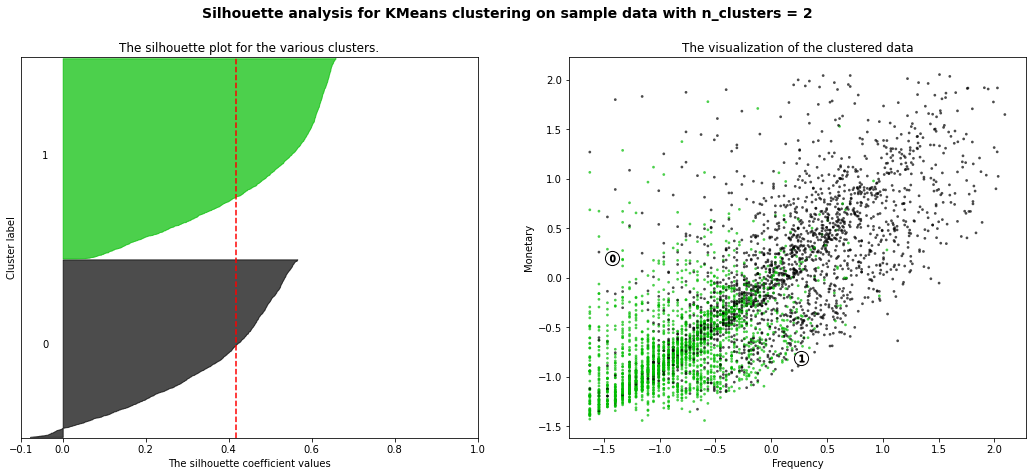

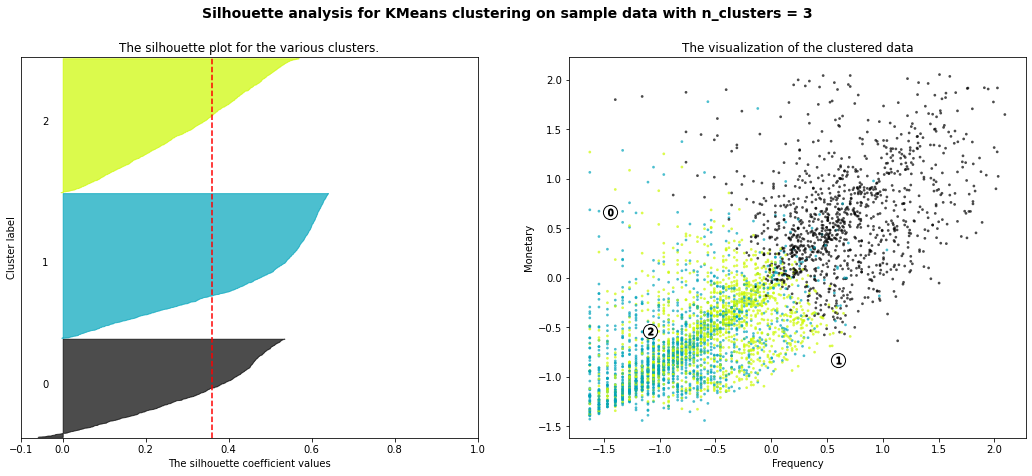

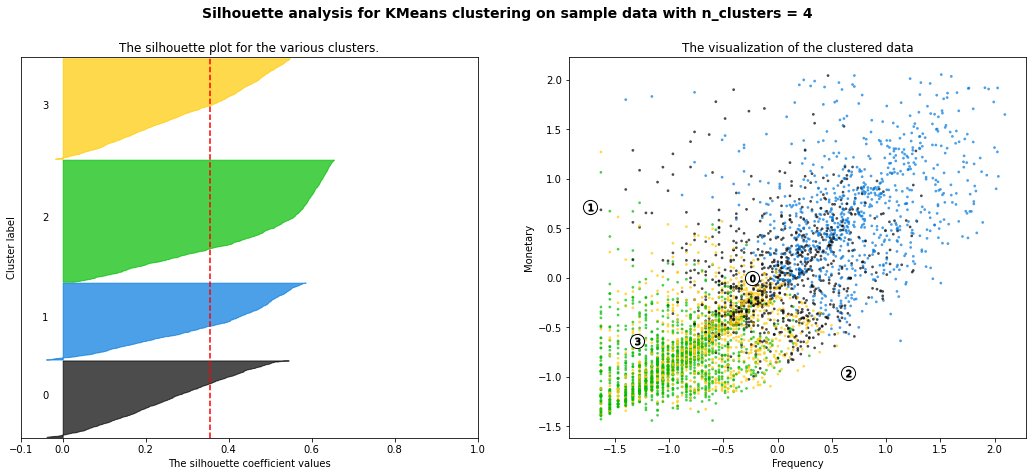

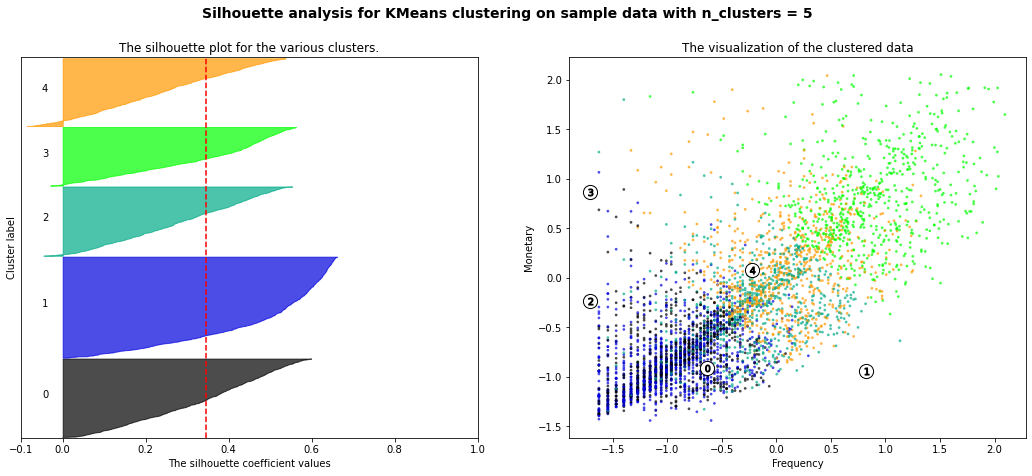

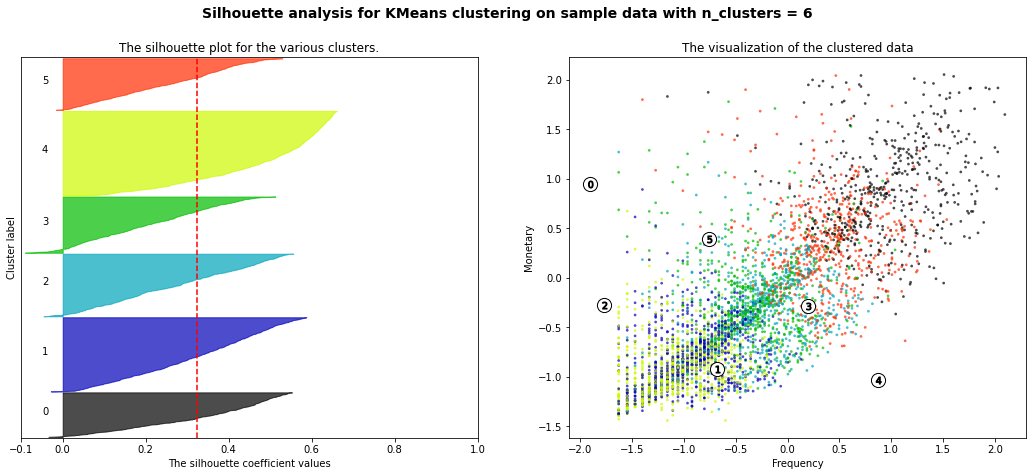

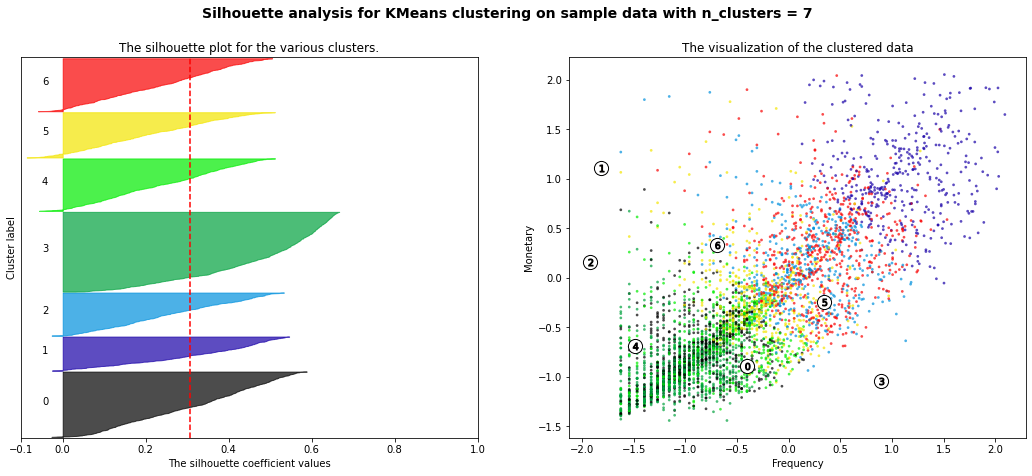

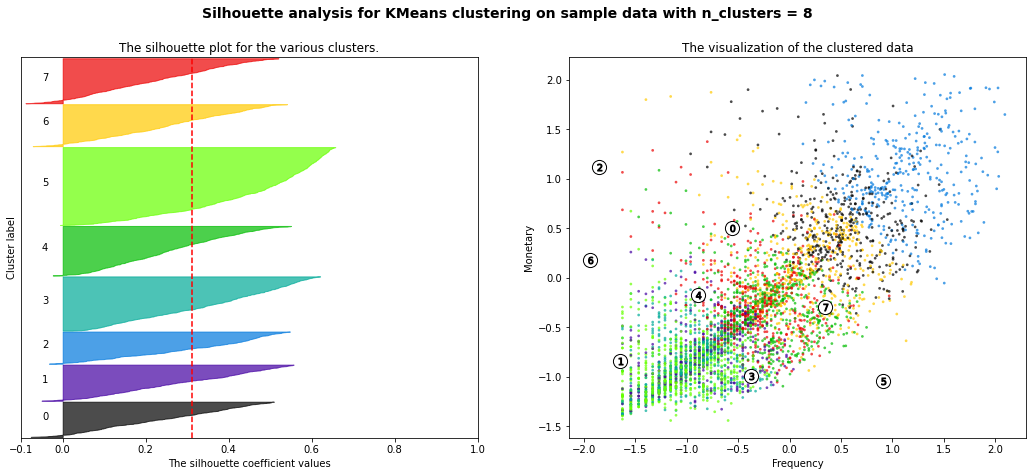

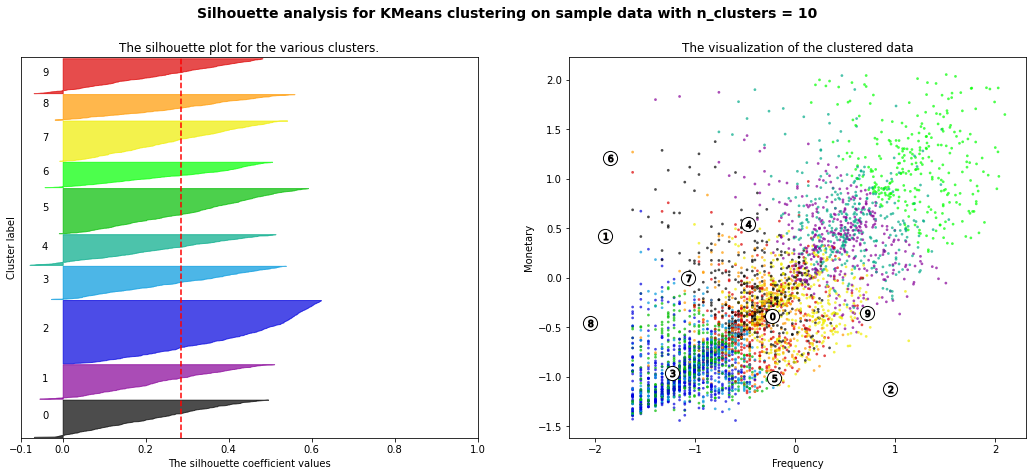

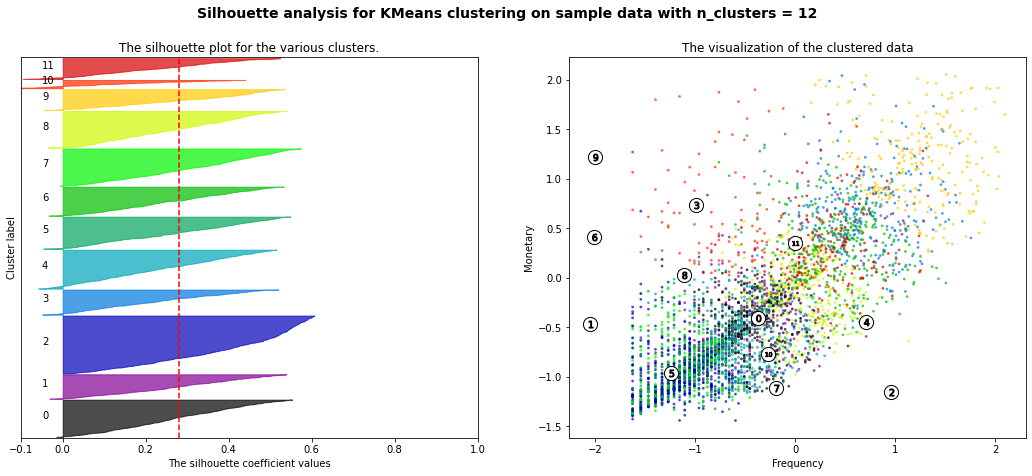

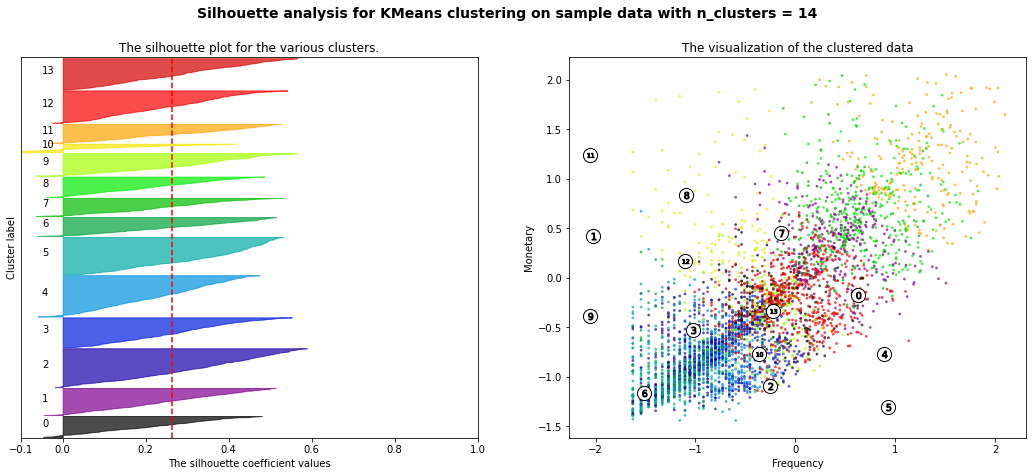

In [ ]:
# Number of clusters confirmation by silhoutte scores
X = df_scaled
range_n_clusters = [2, 3, 4, 5, 6,7,8,10,12,14]
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10,)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X["Frequency"], X["Monetary"], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data")
    ax2.set_xlabel("Frequency")
    ax2.set_ylabel("Monetary")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')



##Centroid Initialization
###Random Initialization of point which results to more number of clusters : We are here just understanding how bad random initialization can predict the clusters 

In [ ]:
centroids = df_scaled.sample(3, random_state = 10)
centroids 

Recency  Frequency  Monetary
707  -0.002163  -0.379330 -0.193826
815  -0.535059   0.292844  0.087954
2168 -0.002163  -0.920278 -0.209179

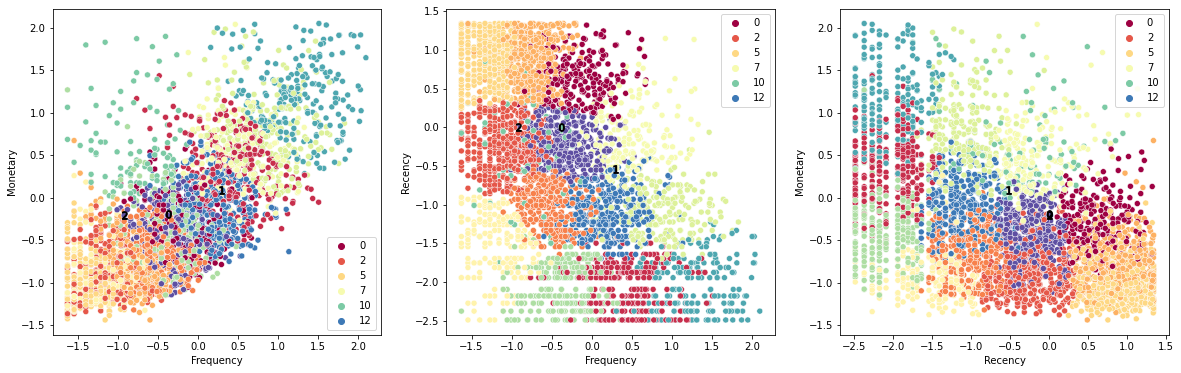

In [ ]:
plt.figure(figsize = (20,6))

plt.subplot(1,3,1)

sns.scatterplot(data = df_scaled, x = 'Frequency', y = 'Monetary', alpha = 1,hue = cluster_labels, palette='Spectral')

for i in range(3):
    plt.scatter(x = centroids['Frequency'].iloc[i], y = centroids['Monetary'].iloc[i], marker = '$%d$' %(i), s=60,color = 'Black')

plt.subplot(1,3,2)

sns.scatterplot(data = df_scaled, x = 'Frequency', y = 'Recency', alpha = 1,hue = cluster_labels, palette='Spectral')

for i in range(3):
    plt.scatter(x = centroids['Frequency'].iloc[i], y = centroids['Recency'].iloc[i], marker = '$%d$' %(i), s=60,color = 'Black')

plt.subplot(1,3,3)

sns.scatterplot(data = df_scaled, x = 'Recency', y = 'Monetary', alpha = 1,hue = cluster_labels, palette='Spectral')

for i in range(3):
    plt.scatter(x = centroids['Recency'].iloc[i], y = centroids['Monetary'].iloc[i], marker = '$%d$' %(i), s=60,color = 'Black')

plt.show()

##Here using Euclidean Distance to find centroids and later checking how far is from the Centroid

In [ ]:
centroids = df_scaled.sample(3, random_state = 10)
centroids 

Recency  Frequency  Monetary
707  -0.002163  -0.379330 -0.193826
815  -0.535059   0.292844  0.087954
2168 -0.002163  -0.920278 -0.209179

In [ ]:
from scipy.spatial.distance import cdist
# cdist returns the distance of each point from the centroid

distances = pd.DataFrame(cdist(df_scaled, centroids,'euclidean'), columns = ['Distance From C0','Distance From C1',
                                                                    
                                                                     'Distance From C2'])

In [ ]:
distances.head()

Distance From C0  Distance From C1  Distance From C2
0          2.920753          2.138921          3.176698
1          0.654904          1.052244          0.658646
2          1.471570          0.923105          1.676725
3          1.564650          2.429707          1.390124
4          1.230009          0.371930          1.628293

In [ ]:
cluster_labels = pd.Series(np.argmin(distances.values, axis = 1))

If you see the results here the clusters are reduced but centroids are not at their optimal positions 

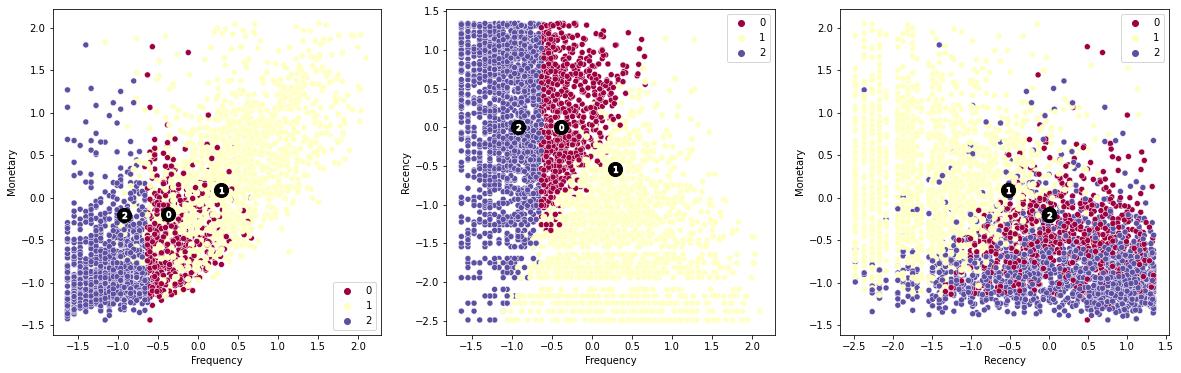

In [ ]:
import matplotlib.cm as cm

plt.figure(figsize = (20,6))

plt.subplot(1,3,1)

sns.scatterplot(data = df_scaled, x = 'Frequency', y = 'Monetary', alpha = 1,hue = cluster_labels, palette='Spectral' )

for i in range(3):
  plt.scatter(x = centroids['Frequency'].iloc[i], y = centroids['Monetary'].iloc[i], s=200, color = 'Black')
  plt.scatter(x = centroids['Frequency'].iloc[i], y = centroids['Monetary'].iloc[i], marker = '$%d$' %(i), s=40, color = 'white')

plt.subplot(1,3,2)

sns.scatterplot(data = df_scaled, x = 'Frequency', y = 'Recency', alpha = 1,hue = cluster_labels, palette='Spectral')

for i in range(3):
    plt.scatter(x = centroids['Frequency'].iloc[i], y = centroids['Recency'].iloc[i], s=200, color = 'Black')
    plt.scatter(x = centroids['Frequency'].iloc[i], y = centroids['Recency'].iloc[i], marker = '$%d$' %(i), s=40, color = 'White')

plt.subplot(1,3,3)

sns.scatterplot(data = df_scaled, x = 'Recency', y = 'Monetary', alpha = 1,hue = cluster_labels, palette='Spectral')

for i in range(3):
    plt.scatter(x = centroids['Recency'].iloc[i], y = centroids['Monetary'].iloc[i], s=200, color = 'Black')
    plt.scatter(x = centroids['Recency'].iloc[i], y = centroids['Monetary'].iloc[i], marker = '$%d$' %(i), s=40,color = 'White')

plt.show()


##Updating the centroid using arithmetic mean 
To find the new centroid, compute the arithmetic mean of the points for each dimension.

In [ ]:
new_centroids = []
K=3
for i in range(K):
    new_centroids.append(list(df_scaled[cluster_labels == i].mean().values))
    
new_centroids = pd.DataFrame(new_centroids, columns = df_scaled.columns, index = ['C0', 'C1','C2'])
new_centroids

Recency  Frequency  Monetary
C0  0.146260  -0.316743 -0.433557
C1 -1.410335   0.336429  0.238886
C2  0.095778  -1.079656 -0.822092

Now Centroids are moved to center of their own clusters and in the above clusters right most graph 0 cluster was not visible now it got its own centroid

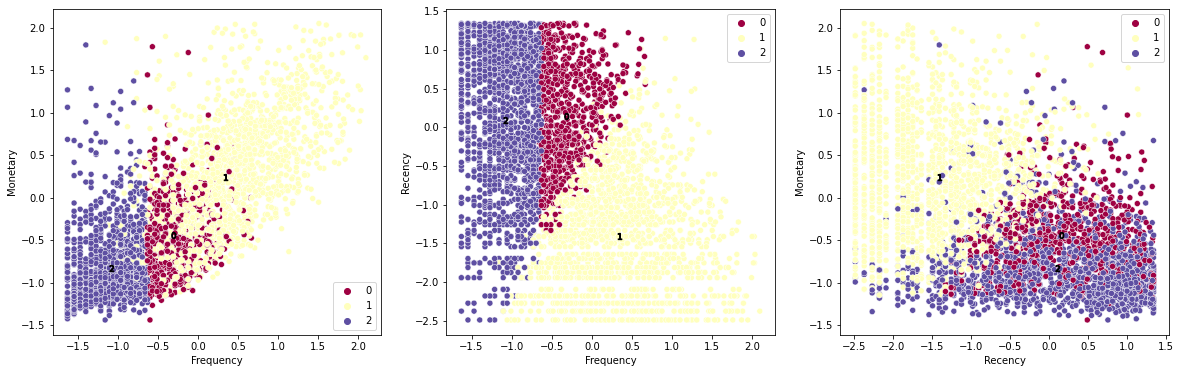

In [ ]:
plt.figure(figsize = (20,6))

plt.subplot(1,3,1)

sns.scatterplot(data = df_scaled, x = 'Frequency', y = 'Monetary',alpha = 1,hue = cluster_labels, palette='Spectral')

for i in range(3):
    plt.scatter(x = new_centroids['Frequency'].iloc[i], y = new_centroids['Monetary'].iloc[i], marker = '$%d$' %(i), s=40,color = 'Black')

plt.subplot(1,3,2)

sns.scatterplot(data = df_scaled, x = 'Frequency', y = 'Recency',alpha = 1,hue = cluster_labels, palette='Spectral')

for i in range(3):
    plt.scatter(x = new_centroids['Frequency'].iloc[i], y = new_centroids['Recency'].iloc[i], marker = '$%d$' %(i), s=40,color = 'Black')

plt.subplot(1,3,3)

sns.scatterplot(data = df_scaled, x = 'Recency', y = 'Monetary',alpha = 1,hue = cluster_labels, palette='Spectral')

for i in range(3):
    plt.scatter(x = new_centroids['Recency'].iloc[i], y = new_centroids['Monetary'].iloc[i], marker = '$%d$' %(i), s=40,color = 'Black')

plt.show()

##Assigning New Lables and New Cluster Centroids


In [ ]:
# cdist returns the distance of each point from the centroid

new_distances = pd.DataFrame(cdist(df_scaled, new_centroids,'euclidean'), columns = ['Distance From C0','Distance From C1',
                                                                     'Distance From C2'])
new_distances.head()


Distance From C0  Distance From C1  Distance From C2
0          3.128063          1.343970          3.616000
1          0.933855          1.581472          1.292118
2          1.681320          0.403920          2.078597
3          1.383910          3.177476          1.071995
4          1.406565          0.582060          2.062256

In [ ]:
new_cluster_labels = pd.Series(np.argmin(new_distances.values, axis = 1))

# displaying labels assigned to the first five rows
new_cluster_labels.head()


0    1
1    0
2    1
3    2
4    1
dtype: int64

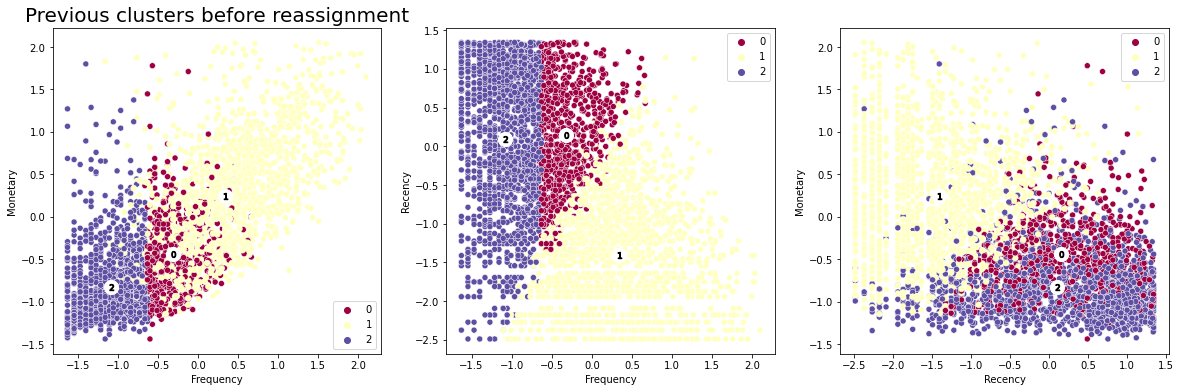

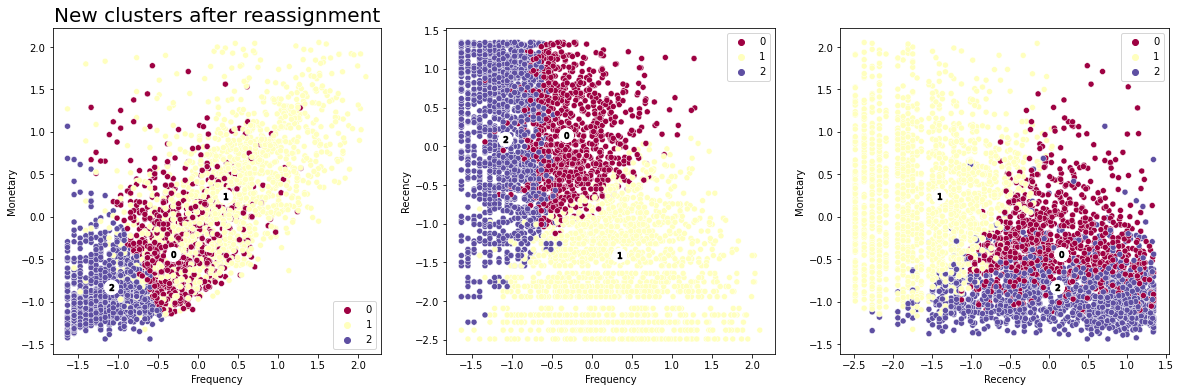

In [ ]:
plt.figure(figsize = (20,6))


plt.subplot(1,3,1)

sns.scatterplot(data = df_scaled, x = 'Frequency', y = 'Monetary', alpha = 1,hue = cluster_labels, palette='Spectral' )

for i in range(3):
    plt.scatter(x = new_centroids['Frequency'].iloc[i], y = new_centroids['Monetary'].iloc[i], s=200, color = 'White')
    plt.scatter(x = new_centroids['Frequency'].iloc[i], y = new_centroids['Monetary'].iloc[i], marker = '$%d$' %(i), s=40, color = 'black')

plt.title('Previous clusters before reassignment', fontdict = {'fontsize' : 20})        
    
plt.subplot(1,3,2)

sns.scatterplot(data = df_scaled, x = 'Frequency', y = 'Recency', alpha = 1,hue = cluster_labels, palette='Spectral')

for i in range(3):
    plt.scatter(x = new_centroids['Frequency'].iloc[i], y = new_centroids['Recency'].iloc[i], s=200, color = 'White')
    plt.scatter(x = new_centroids['Frequency'].iloc[i], y = new_centroids['Recency'].iloc[i], marker = '$%d$' %(i), s=40, color = 'Black')

plt.subplot(1,3,3)

sns.scatterplot(data = df_scaled, x = 'Recency', y = 'Monetary', alpha = 1,hue = cluster_labels, palette='Spectral')

for i in range(3):
    plt.scatter(x = new_centroids['Recency'].iloc[i], y = new_centroids['Monetary'].iloc[i], s=200, color = 'White')
    plt.scatter(x = new_centroids['Recency'].iloc[i], y = new_centroids['Monetary'].iloc[i], marker = '$%d$' %(i), s=40,color = 'Black')

plt.show()


plt.figure(figsize = (20,6))

plt.subplot(1,3,1)

sns.scatterplot(data = df_scaled, x = 'Frequency', y = 'Monetary', alpha = 1,hue = new_cluster_labels, palette='Spectral' )

plt.title('New clusters after reassignment', fontdict = {'fontsize' : 20})     

for i in range(3):
    plt.scatter(x = new_centroids['Frequency'].iloc[i], y = new_centroids['Monetary'].iloc[i], s=200, color = 'White')
    plt.scatter(x = new_centroids['Frequency'].iloc[i], y = new_centroids['Monetary'].iloc[i], marker = '$%d$' %(i), s=40, color = 'black')

plt.subplot(1,3,2)

sns.scatterplot(data = df_scaled, x = 'Frequency', y = 'Recency', alpha = 1,hue = new_cluster_labels, palette='Spectral')

for i in range(3):
    plt.scatter(x = new_centroids['Frequency'].iloc[i], y = new_centroids['Recency'].iloc[i], s=200, color = 'White')
    plt.scatter(x = new_centroids['Frequency'].iloc[i], y = new_centroids['Recency'].iloc[i], marker = '$%d$' %(i), s=40, color = 'Black')

    

plt.subplot(1,3,3)

sns.scatterplot(data = df_scaled, x = 'Recency', y = 'Monetary', alpha = 1,hue = new_cluster_labels, palette='Spectral')

for i in range(3):
    plt.scatter(x = new_centroids['Recency'].iloc[i], y = new_centroids['Monetary'].iloc[i], s=200, color = 'White')
    plt.scatter(x = new_centroids['Recency'].iloc[i], y = new_centroids['Monetary'].iloc[i], marker = '$%d$' %(i), s=40,color = 'Black')

plt.show()

There is some change in clusters <br>
To make it clearer, lets visualise this shift in cluster size with bar plots.



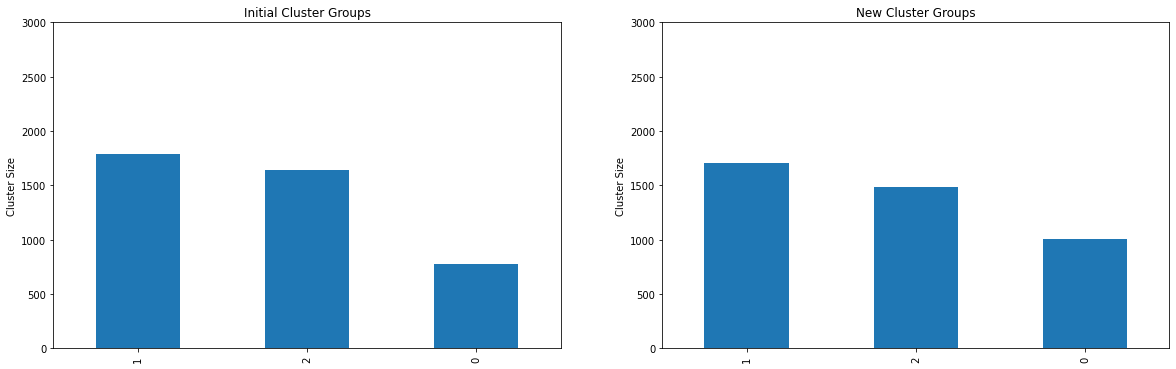

In [ ]:
plt.figure(figsize = (20,6))

plt.subplot(1,2,1)

plt.title('Initial Cluster Groups')

plt.ylabel('Cluster Size')

plt.ylim(0,3000)

cluster_labels.value_counts().plot(kind = 'bar')

plt.subplot(1,2,2)

plt.title('New Cluster Groups')

plt.ylim(0,3000)

plt.ylabel('Cluster Size')


new_cluster_labels.value_counts().plot(kind = 'bar')

plt.show()

#Conclusion
1. We dropped the nulls and duplicated from the data and dropped some columns 
We Cannot impute null values because the columns which has null values cannot really imputed (Description and Customer ID)

2. Since its sales data we used RFM (Recency , Frequency, Monetary) to from the data to get the proper results 

3. We used the same dataset and removed outliers and selected only Q1-Q3 data and then we used standard scaler to make balance of data in mean and standard deviation.

4. We did log transform to get proper distribution of data

5. Implemented k- means and played with centroids to fit the centroid in between of clusters and eventually increase cluster size to get proper visuals.
